**Navn på gruppens medlemmer:**

*Levér en ferdig kjørt notebook som inkluderer alle resultater, helst eksportert som HTML-dokument. Det er tilstrekkelig at ett gruppemedlem leverer på vegne av alle i gruppa.*

# Om de numeriske øvingene i kvantemekanikk

Målet med de numeriske øvingene i kvantemekanikk er
* å bruke numeriske metoder og visualiseringer for å forstå kvantemekanikk bedre.
* å utvikle en generell "verktøykasse" du kan bruke også når du arbeider med andre øvinger og lærer nytt stoff i faget.
* å se ligningene i kvantemekanikken og løsninger av disse fra et generelt perspektiv.
* å utvikle ferdigheter innen programmering og numerikk.

Vi legger opp til bruk av Python sammen med bibliotekene `numpy`, `scipy` og `matplotlib` for numerikk, vitenskapelige beregninger og plotting.
*Bruk disse for alt de er verdt!*
God bruk av disse bibliotekene vil la deg uttrykke deg mer konsist enn om du kun bruker standard Python-funksjonalitet.
Vi forventer at du selv finner fram til relevant funksjonalitet og dokumentasjon i bibliotekene.
De er alle godt dokumentert på Internett.

Om du selv ønsker å benytte andre programmeringsspråk eller biblioteker, står du fritt til det.
Noen oppgaver inkluderer en liten mengde hjelpekode i Python som du i så fall må omskrive på egen hånd, men de er ellers utformet uten tilknytning til et spesifikt språk.
Vi forventer likevel at du leverer et alternativt, sammenhengende dokument med tekst, kode og resultater som svarer på oppgavene.

I Jupyter Notebook og Jupyter Lab er det mulig å bruke ulike *backends* for plotting med `matplotlib`.
Dette er grovt forklart forskjellige underliggende "motorer" som bestemmer utseende og funksjonaliteten til figurene som produseres.
Avhengig av hvilket av programmene du bruker, vil du erfare at en backend fungerer bedre enn andre.
I Jupyter Notebook fungerer `notebook`-backenden best og uten behov for installasjon av ekstra programvare, men i Jupyter Lab må tillegget [jupyter-matplotlib](https://github.com/matplotlib/jupyter-matplotlib) installeres for å få den optimale `widget`-backenden til å fungere.
Begge programmene støtter også `inline`-backenden uten behov for tilleggsprogramvare, men denne produserer mindre fleksible figurer og bør kun brukes som reserveløsning.
Prøv deg selv fram med backendene foreslått under for å finne den som fungerer best for deg.

In [1]:
# uncomment ONE line to choose matplotlib backend
# if using Jupyter Notebook, use interactive "notebook" backend for best results
# if using Jupyter Lab, use interactive "widget" backend for best results
# if both fail, use static "inline" backend
#%matplotlib notebook 
#%matplotlib widget 
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate

## Kort om fysiske enheter i numeriske beregninger

I numeriske beregninger må vi ta hensyn til den begrensede presisjonen og størrelsen til flyttallene som datamaskinen bruker for å representere relle tall.
I kvantemekanikken møter vi spesielt ofte på Plancks reduserte konstant $\hbar \approx 6.63 \cdot 10^{-34} \text{ Js}$ og gjerne kvadratet $\hbar^2$. Det er i utgangspunktet ingenting i veien for å benytte SI-enheter for alle størrelser som opptrer i disse øvingene. Et alternativ er å benytte [atomære enheter](https://en.wikipedia.org/wiki/Hartree_atomic_units).
Dette enhetssystemet er skreddersydd for beregninger på atomært nivå.
Her er blant annet $\hbar$, elektronmassen $m_e$ og elementærladningen $e$ *definert* til å ha tallverdi $1$.
For eksempel uttrykkes energier som multipler av én hartree, $E_h = \hbar^2 / m_e a_0^2 \approx 4.36 \cdot 10^{-18} \text{ J}$. En annen løsning er å benytte enheter som $\text{nm}$ og $\text{eV}$ for lengder og energier. En hartree tilsvarer ca. 27.2 eV, dvs. det dobbelte av grunntilstandsenergien i hydrogenatomet.

**Velg selv hensiktsmessige enheter til bruk i beregningene, men vær oppmerksom på den begrensede presisjonen til flyttall!**

In [2]:
#Konstanter
h = 6.63*10**(-34)
m_e = 9.11*10**(-31)
V_0 = np.zeros(int(10/0.1))
N = 2 #Antall bølgefunksjoner jeg ser på

# Numerisk løsning av den tidsuavhengige Schrödingerligningen

Å løse den tidsuavhengige Schrödingerligningen
$$ \hat{H} \psi = -\frac{\hbar^2}{2 m} \psi'' + V \psi = E \psi, $$
dvs. å bestemme energiegenverdier $E$ og tilhørende energiegenfunksjoner $\psi(x)$ for et gitt potensial $V(x)$, er et sentralt problem i kvantemekanikken. Dette er ofte ingen enkel oppgave.
Selv for potensialer som gir ligningen analytiske løsninger, kreves det ofte betydelig innsats og bruk av spesielle teknikker for å komme fram til disse.
Vi skal her se på en elegant og generell teknikk for å løse ligningen numerisk for et vilkårlig potensial (i én dimensjon).

Numeriske løsningsmetoder innebærer alltid en viss avgrensning og diskretisering for å gjøre problemet endelig og håndterlig for en datamaskin. Vi avgrenser her delen av rommet vi ser på til å ligge mellom to endepunkter $x_0$ og $x_{N+1}$ og deler opp intervallet mellom dem i punktene $x_0, x_1, \ldots, x_N, x_{N+1}$ med lik avstand $\Delta x$ mellom hvert punkt.
Utenfor dette området definerer vi potensialet til $V(x \leq x_0) = V(x \geq x_{N+1}) = \infty$, slik at $\psi(x \leq x_0) = \psi(x \geq x_{N+1}) = 0$ og det kun er bølgefunksjonens verdier på rutenettet $\boldsymbol{x} = [x_1, \ldots, x_N]^T$ som er ukjente og av interesse.
Til hvert punkt tilordner vi verdiene $\psi_i = \psi(x_i)$ og $V_i = V(x_i)$ til energiegenfunksjonene og potensialet, og vi refererer til verdiene av funksjonene i alle punktene ved hjelp av vektorene $\boldsymbol{V} = [V_1, \ldots, V_N]^T$ og $\boldsymbol{\psi} = [\psi_1, \ldots, \psi_N]^T$.

En intuitiv og enkel tilnærming av den deriverte til en funksjon er den sentrale differansen
$$ \psi'(x) = \frac{\psi(x + \Delta x / 2) - \psi(x - \Delta x / 2)}{\Delta x} $$
Om vi bruker denne tilnærmingen to ganger, kan vi også tilnærme den andrederiverte som
$$ \psi''(x) = \frac{\psi'(x + \Delta x / 2) - \psi'(x - \Delta x / 2)}{\Delta x} = \frac{\psi(x + \Delta x) - 2 \psi(x) + \psi(x - \Delta x)}{\Delta x^2}$$

Ved å sette denne tilnærmingen inn i den tidsuavhengige Schrödingerligningen, kan vi tilnærme den numerisk som
$$-\frac{\hbar^2}{2 m} \frac{\psi_{i+1} - 2 \psi_i + \psi_{i-1}}{{\Delta x}^2} + V_i \psi_i = E \psi_i \qquad \text{for}\,\, i = 1, 2, \ldots, N$$

Vi kan uttrykke denne ligningen på en elegant måte ved å innføre $N \times N$-Hamiltonmatrisen $H$ med elementer
$$ H_{i j} = \begin{cases} 
    \hbar^2 / (m \Delta x^2) + V_i & \text{for} \,\, i = j         & \text{(på diagonalen)}        \\ 
    -\hbar^2 / (2 m \Delta x^2)    & \text{for} \,\, i = j \pm 1   & \text{(på semidiagonalene)}   \\
    0                              & \text{ellers}                                                 \\
\end{cases} $$
og benytte oss av vektoren $\boldsymbol{\psi} = [\psi_1, \ldots, \psi_N]^T$.
Den tar da formen
$$ H \boldsymbol{\psi} = E \boldsymbol{\psi} $$
Energiene $E$ og energiegenfunksjonene $\boldsymbol{\psi}$ er dermed egenverdier og egenvektorer til matrisen $H$!

Numerikkbiblioteker har funksjonalitet for å finne egenverdier og egenvektorer til vilkårlige matriser.
De har gjerne også spesialiserte funksjoner som gjør dette mer effektivt for matriser med en spesiell form, for eksempel som den *tridiagonale* (samt reelle og symmetriske) formen til matrisen $H$.

**Skriv en funksjon som beregner og returnerer alle energiegenverdier $E$ og tilhørende energiegenfunksjoner $\boldsymbol{\psi}$ for en partikkel med masse $m$ som befinner seg i et gitt potensial $\boldsymbol{V}$ på rutenettet $\boldsymbol{x}$. Normér energiegenfunksjonene i forstanden $\int |\psi|^2 \mathrm{d}x$ = 1.**

In [38]:
def Hamilton(m,dx,V,L_v):
    n = int(L_v/dx)
    H = np.zeros((n,n))
    for i in range(0,n):
        H[i,i] = h**2/(m*(dx**2))+V[i]
        for j in range(0,n):
            if i == j+1:
                H[i,j] = (-h**2/(2*m*(dx**2)))
            elif i == j-1:
                H[i,j] = (-h**2/(2*m*(dx**2)))
    return H

def TUSL(m,dx,V,L_v):
    
    H = Hamilton(m,dx,V,L_v)
    eigvals, eigvecs = np.linalg.eig(H)
    E, Psi = eigvals, eigvecs.T
    n = int(L_v/dx) 
    
    for i in range(0,n):
        norm = np.sum((abs(Psi[i]))**2)*dx
        Psi[i] /= norm**(1/2)
    print()
    return E, Psi





I resten av øvingen skal vi rett og slett bare bruke denne numeriske løsningsmetoden på en rekke forskjellige potensialer.
I noen av eksemplene skal vi også sammenligne de numeriske verdiene med analytiske resultater.
For å gjøre denne prosessen så enkel som mulig, foreslår vi at du her skriver én "ultimat" plottefunksjon som du kan gjenbruke i alle disse oppgavene.

**Skriv en funksjon som framstiller potensialet $\boldsymbol{V}$, energiegenverdier $E$ og energiegenfunksjoner $\boldsymbol{\psi}$ (eller absoluttkvadratene $|\boldsymbol{\psi}|^2$) på rutenettet $\boldsymbol{x}$ grafisk. Funksjonen skal også kunne brukes til å sammenligne to sett med (numeriske og analytiske) energier og energiegenfunksjoner.**

**Gjør gjerne dette parallelt med resten av oppgavene, slik at du kan tilpasse framstillingen basert på behovene som oppstår. Se gjerne i forelesningsnotater, bøker og søk rundt på Internett for å få litt inspirasjon til hvordan framstillingen kan gjøres.**

In [28]:
def plot_easy(E_Num, Psi_Num,E_An, Psi_An,x, V, N, m, Y):
    
    
    fig= plt.figure(1)
    for i in range(0,N):
        plt.plot(x, np.abs(Psi_Num[i])**2, label=f'Numerisk \psi(x){i+1}')
        if Y ==1:
            plt.plot(x, Psi_An[:,i], label=f'Analytisk \psi(x){i+1}')
        plt.xlabel("Distanse")
        plt.ylabel("Psi")
    plt.legend()
        
    fig = plt.figure(2)
    for i in range(0,N):
        plt.plot(x, (E_Num[i]+0*x)/(1.602*10**(-19)), label=f'Numerisk E (lag{i+1})')
        if Y ==1:
            plt.plot(x, (E_An[i]+0*x)/(1.602*10**(-19)), label=f'Analytisk E (lag{i+1})')
        plt.xlabel("Distanse")
        plt.ylabel("eV")
    plt.legend()




## Partikkel i boks

Et av de første kvantemekaniske problemene vi støter på er partikkel i boks.
Her er potensialet, de normerte energiegenfunksjonene og energiegenverdiene
$$
V(x) = \begin{cases}0 & \text{for}\,\, 0 \leq x \leq L \\ \infty & \text{ellers} \end{cases},
\quad \psi(x) = \sqrt{\frac{2}{L}} \sin{\frac{n \pi x}{L}}, 
\quad E = \frac{n^2 \pi^2 \hbar^2}{2 m L^2},
\quad \quad n = 1, 2, \ldots,
$$

**Sammenlign numeriske og analytiske verdier for noen energier og energiegenfunksjoner for et elektron i en boks grafisk.**

**Hvordan er spredningen i energinivåene?**

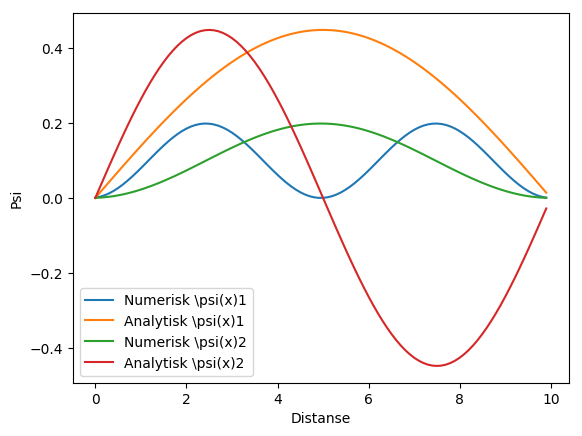

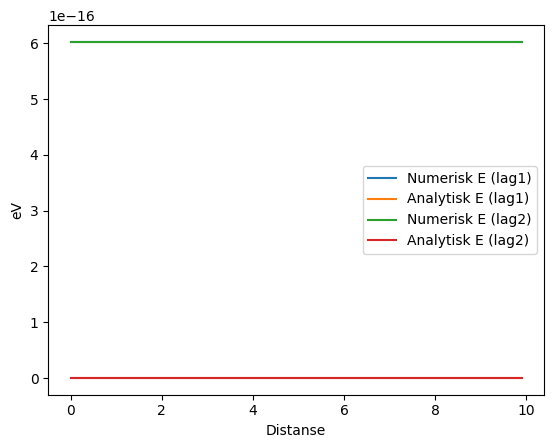

In [39]:
#Ettersom spenningen er "uendelig" når x<0, x>L ser jeg bare på området innenfor.
#Oppgave spesifike variabler
dx = 0.1
L = 10
k = int(L/dx)
x = np.arange(0,10,dx)
V = np.zeros(k)

E_Num, Psi_Num = TUSL(m_e,dx,V,L)

Psi_An=np.zeros((k,N))
for i in range(0,N):
    Psi_An[:,i] = np.sqrt(2/L)*np.sin(((i+1)*np.pi*x)/L)
E_An = np.zeros(N)
for i in range(0,N):
    E_An[i] = ((i+1)**2*np.pi**2*h**2)/(2*m_e*L**2)
    

plot_easy(E_Num, Psi_Num,E_An,Psi_An,x, V, N, m_e,1)

## Harmonisk oscillator

Et annet standard kvantemekanisk problem er den harmoniske oscillatoren med
$$
V(x) = \frac{1}{2}m \omega^2 x^2,
\quad \psi(x) = \frac{1}{\sqrt{2^n n!}} \cdot \left(\frac{m \omega}{\pi \hbar}\right)^{1/4} \cdot \exp{\left(-\frac{m \omega x^2}{2 \hbar}\right)} \cdot H_n\left(\sqrt{\frac{m \omega}{\hbar}}x\right),
\quad E = \left(n+\frac{1}{2}\right)\hbar \omega,
\quad \quad n = 0, 1, 2, \ldots
$$
Funksjonene $H_n(y)$ (med dimensjonsløs $y$) kalles [(fysikerens) Hermitepolynomer](https://en.wikipedia.org/wiki/Hermite_polynomials).
De er tilgjengelige i numerikkbiblioteker, men kan også beregnes fra rekursjonsrelasjonen
$$ H_n(x) = 2 x H_{n-1}(x) - 2 (n-1) H_{n-2}(x), \quad H_0(x) = 1, \quad H_1(x) = 2 x$$

Den harmoniske oscillatoren er spesielt interessant i topartikkelsystemer, der et problem med for eksempel to atomer med masse $m_1$ og $m_2$ i et toatomig molekyl reduseres til et ekvivalent enpartikkelproblem med *redusert masse* $m = m_1 m_2 / (m_1 + m_2)$.
Sammen med konstanten $\omega$ utgjør denne et mål på en fjærkonstant som beskriver vibrasjonsbevegelsen mellom de to atomene.

**Sammenlign numeriske og analytiske verdier for noen energier og energiegenfunksjoner i en harmonisk oscillator grafisk.**

**Hvordan er spredningen i energinivåene?**

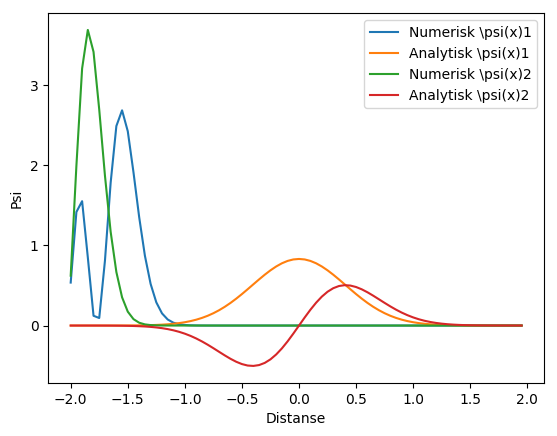

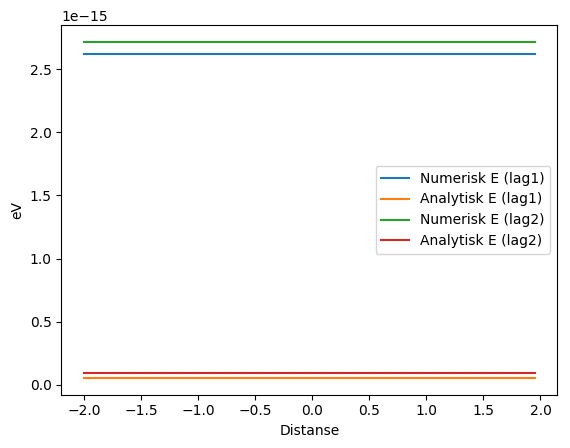

In [40]:
# Oppgave spesifikke variabler
w = 1/2*np.pi/180
dx = 0.05
L = 4 #Verdier under 4 gir uventede resultater
k = int(L/dx)
m = (m_e*m_e)/(m_e+m_e)
x = np.arange(-0.5*L,0.5*L,dx)
V = 0.5*m*w**2*x**2



def Psi_Ana(n,x):
    y = np.sqrt(m*w/h)*x
    if n == 1:
        Hermite = 1
        return 1/np.sqrt(2**n*np.math.factorial(n))*((m*w)/(np.pi*h))**(1/4)*np.e**(-(m*w*x**2)/(2*h))*Hermite
    elif n == 2:
        Hermite = 2*y
        return 1/np.sqrt(2**n*np.math.factorial(n))*((m*w)/(np.pi*h))**(1/4)*np.e**(-(m*w*x**2)/(2*h))*Hermite
    else:
        Hermite_1 = 1
        Hermite_2 = 2*y
        for i in range(3,n):
            Hermite_3 = 2*y*Hermite_2-2*(i-1)*Hermite_1
            Hermite_1 = Hermite_2
            Hermite_2 = Hermite_3
        return 1/np.sqrt(2**n*np.math.factorial(n))*((m*w)/(np.pi*h))**(1/4)*np.e**(-(m*w*x**2)/(2*h))*Hermite_3
    
def E_Ana(n):
    return (n+0.5)*w*h

Psi_An = np.zeros((k,N))
E_An = np.zeros(N)

for j in range(1,N+1):
    E_An[j-1] = E_Ana(j)
    Psi_An[:,j-1] = Psi_Ana(j,x)

E_Num, Psi_Num = TUSL(m_e,dx,V,L)
    
plot_easy(E_Num, Psi_Num,E_An,Psi_An,x , V, N, m_e,1)


## Partikkel i endelige brønnpotensialer

Et tredje velkjent eksempel er enkeltbrønnen
$$V(x) = \begin{cases}
-V_0 & \text{for}\,\, 0 < x < w \\ 
0   & \text{ellers}
\end{cases}$$
med bredde $w$ og brønndybde $V_0 > 0$.
I dette potensialet finnes ingen analytiske løsninger for de bundne stasjonære tilstandenes energiegenverdier.

Enkeltbrønnen kan generaliseres til et potensial bestående av $N_w$ slike enkeltbrønner plassert ved siden av hverandre med en fast avstand $g$ mellom hver brønn.
Med første brønn i $x = 0$, kan vi uttrykke det sammensatte brønnpotensialet stykkevis som

$$V(x) = \begin{cases}
0    & \text{for}\,\, x < 0 \,\, \text{og} \,\, x > N_w (w + g) & \text{(utenfor brønnområdet)} \\
-V_0 & \text{for}\,\, \frac{x}{w+g} - \left\lfloor \frac{x}{w+g} \right\rfloor < \frac{w}{w+g} & \text{(i brønnene)} \\
0    & \text{ellers} & \text{(mellom brønnene)} \\
\end{cases}$$

Dette er en enkel modell for det periodiske potensialet som et elektron opplever i et fast stoff med en regulær krystallinsk struktur, for eksempel et metall.

**Framstill de bundne tilstandene for et elektron både i en enkeltbrønn og i et sammensatt potensial bestående av mange brønner grafisk. Legg inn et passe stort område med $V = 0$ på begge sider av brønnområdet.**

**Hvordan distribueres energinivåene i potensialet bestående av mange brønner sammenlignet med enkeltbrønnen? Kan du ut fra dette forklare hva vi mener med *energibåndstrukturen* til et fast stoff ved hjelp av begrepene *båndbredde* og *båndgap*?**

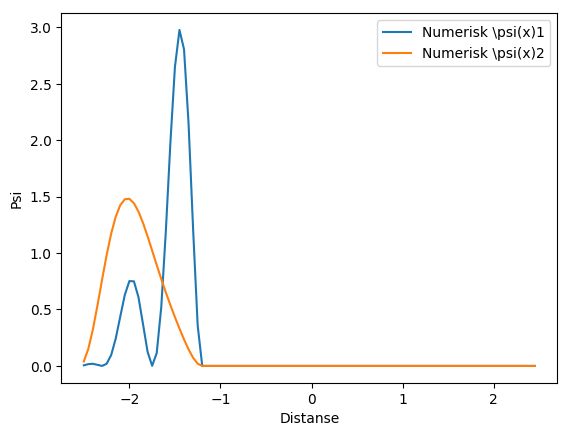

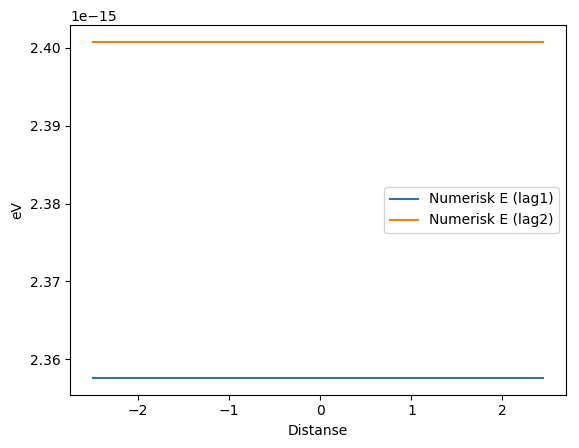

In [41]:
# Oppgave spesifikke variabler
dx = 0.05
V_0 = 2.3 * 10**(-3)
L = 5
x = np.arange(-0.5*L,0.5*L,dx)
k = int(2*L/dx)
m = (m_e*m_e)/(m_e+m_e)
V = np.zeros(len(x))
for i in range(0,len(x)):
    if x[i] < -0.25*L:
        V[i] = 0
    elif -0.25*L < x[i] <0.25*L:
        V[i] = -V_0
    elif x[i] > 0.25*L:
        V[i]=0


        
E_Num, Psi_Num = TUSL(m_e,dx,V,L)
    
plot_easy(E_Num, Psi_Num,E_An, Psi_An, x, V, N, m_e, 0)

